# Figure 2 - Identifying the best ML algorithm to classify COVID-19 cases vs controls generated by the "Recessive-Dominant" inheritance model.

In [47]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.impute
import sklearn.ensemble
import scipy.stats
import matplotlib as mpl
import seaborn as sns
#import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams['figure.dpi'] = 250
pd.set_option('display.max_rows', 50)

df = pd.read_csv("COVID19_GWAS_downsampled_population.csv", sep=",", header=0, index_col=0)
display(df)

,class,rs140604514,rs75811734,rs12127714,rs12139500,rs190204955,rs56270766,rs10922911,rs10801825,rs10801826,...,rs113439507,rs112426803,rs111718325,rs75585764,rs74766371,rs9983330,rs12329760,rs150868259,rs142121339,rs191514675
subject,,,,,,,,,,,,,,,,,,,,,
s3787,case,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
s1411,case,0,0,0,0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,0,0
s5344,case,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
s2724,case,0,0,0,0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,0,0
s4299,case,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s677626,control,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
s330941,control,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
s754782,control,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,1,1,0,0,0


## Lets split the dataset into testing and training-validation with a 15/85 split, respectively 

In [2]:
def datasplitter(dataframe):
    df_trainvalid = pd.DataFrame()
    df_test = pd.DataFrame()
    for patient in dataframe["class"].unique():
        df_patient = dataframe[dataframe["class"] == patient]
        test_size = round(len(df_patient)*0.15)
        test_sample = df_patient.sample(n=test_size, replace = False)
        trainvalid_sample = df_patient[~df_patient.index.isin(test_sample.index)]

        df_test = df_test.append(test_sample)
        df_trainvalid = df_trainvalid.append(trainvalid_sample)
    return [df_test,df_trainvalid]    

In [3]:
df_test = datasplitter(df)[0]
X_holdout = df_test.iloc[:,1:]
Y_holdout = df_test["class"]

X = datasplitter(df)[1].iloc[:,1:]
Y = datasplitter(df)[1]["class"]

## To evaluate the performance of each model we will use the below function:

In [4]:
def model_performance(model, X, Y, X_holdout,Y_holdout):
    metrics = {"precision": [],"recall" : [], "f1" : [], "accuracy" : [], "AUROC" : []}
    model.fit(X,Y)
    model_pred = model.predict(X_holdout)
    metrics["precision"].append(precision_score(Y_holdout, model_pred, average="macro"))
    metrics["recall"].append(recall_score(Y_holdout, model_pred, average="macro"))
    metrics["f1"].append(f1_score(Y_holdout, model_pred, average="macro"))
    metrics["accuracy"].append(accuracy_score(Y_holdout, model_pred))
    metrics["AUROC"].append(roc_auc_score(Y_holdout,model.predict_proba(X_holdout)[:,1]))
    
    return [pd.DataFrame(metrics), model_pred]

# Random forest hyperparameter tuning

In [16]:
forest = RandomForestClassifier()
n_estimators = [50,100,500,1000]
max_features = ["sqrt", "log2", None]
max_depth = [None,5,10,50,100]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1,2,5]
bootstrap = [True]
criterion = ["gini","entropy"]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion' : criterion}

forest_variants = RandomizedSearchCV(estimator = forest, param_distributions = grid, n_iter = 50, cv = 2, verbose=2, random_state=42)
forest_variants.fit(X,Y)
forest_variants.best_params_

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END bootstrap=True, criterion=gini, max_depth=50, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=1000; total time= 5.7min
[CV] END bootstrap=True, criterion=gini, max_depth=50, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=1000; total time= 7.8min
[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   3.7s
[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 4.1min
[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 4.2min
[CV] E

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': True}

## Comparing the baseline and optimized random forest performance

In [40]:
rf_baseline = model_performance(model = RandomForestClassifier(),X=X,Y=Y,X_holdout=X_holdout,Y_holdout = Y_holdout)[0]
rf_optimized,rf_pred = model_performance(model = RandomForestClassifier(**{'n_estimators': 50, 'min_samples_split': 5,'min_samples_leaf': 1,'max_features': None,'max_depth': None,'criterion': 'entropy','bootstrap': True}),
                                 X=X,Y=Y,X_holdout = X_holdout,Y_holdout = Y_holdout)

In [41]:
rf_performance = pd.concat([rf_baseline,rf_optimized], axis = 0,ignore_index = True)
rf_performance = rf_performance.rename(index = {0 : "baseline_randomforest", 1 : "optimized_randomforest"})
rf_performance


,precision,recall,f1,accuracy,AUROC
baseline_randomforest,0.877193,0.874049,0.873786,0.874049,0.961586
optimized_randomforest,0.877379,0.874894,0.874688,0.874894,0.961694


## Optimized random forest confusion matrix 

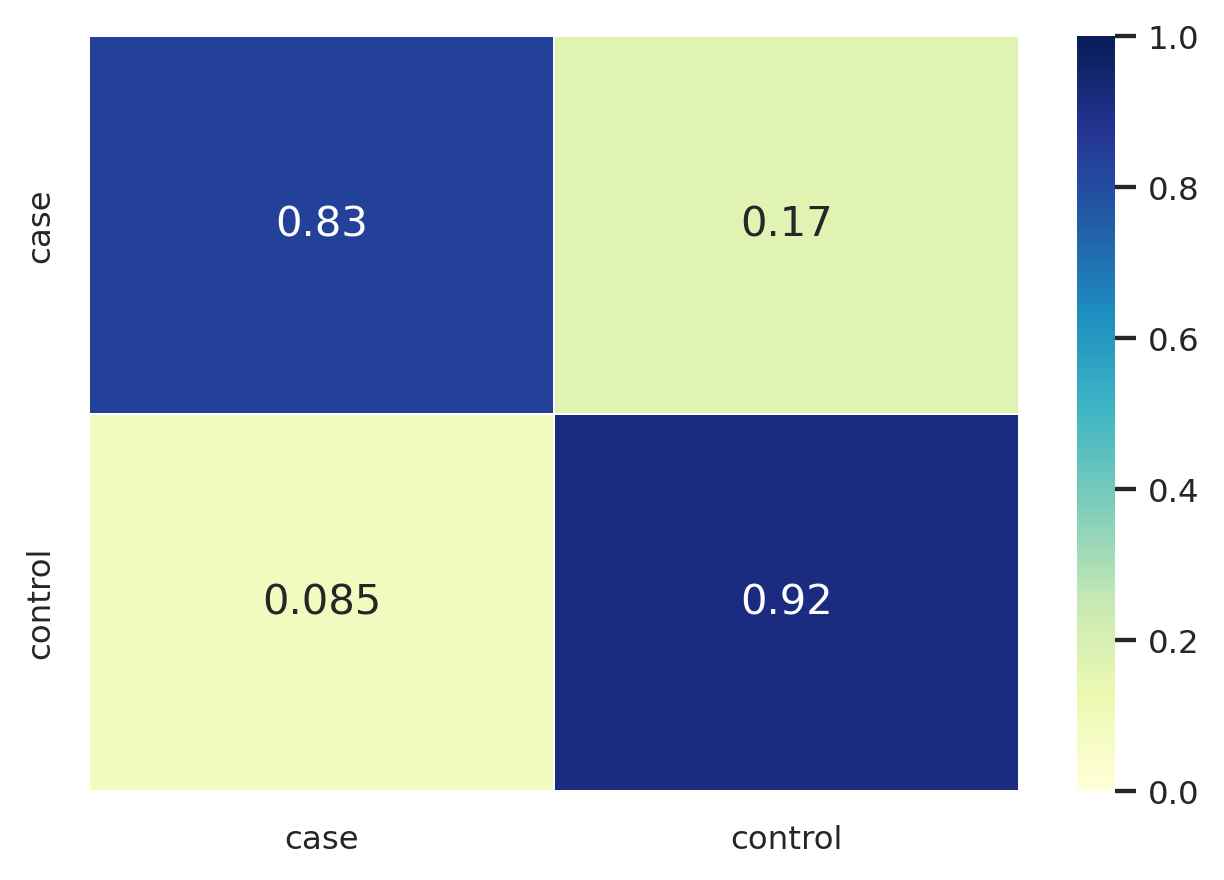

In [43]:
matrix = confusion_matrix(Y_holdout,rf_pred, labels=np.unique(Y_holdout))
matrix = matrix/matrix.sum(axis=1, keepdims=True)*1
df_matrix = pd.DataFrame(matrix)
df_matrix.columns = np.unique(Y_holdout)
df_matrix.index = np.unique(Y_holdout)

sns.set(font_scale=0.85)
ax = sns.heatmap(df_matrix,cmap ="YlGnBu",annot = True,vmin = 0, vmax = 1,linewidth=0.5,annot_kws={"size": 12})
plt.show()

# Logistic regression hyperparameter tuning

In [20]:
logistic = LogisticRegression()
penalty = ["l1", "l2", "elasticnet", "none"]
C = [0.1,0.5,1,2]
fit_intercept = [True, False]
dual = [True,False]
class_weight = ["balanced", None]
solver = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
max_iter = [10,50,100,200,500]



grid = {'penalty': penalty,
               'C': C,
               'fit_intercept': fit_intercept,
               'dual': dual,
               'class_weight': class_weight,
               'solver': solver,
               'max_iter' : max_iter}

logistic_variants = RandomizedSearchCV(estimator = logistic, param_distributions = grid, n_iter = 50, cv = 2, verbose=2, random_state=42)
logistic_variants.fit(X,Y)
logistic_variants.best_params_

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END C=1, class_weight=None, dual=False, fit_intercept=False, max_iter=500, penalty=l1, solver=saga; total time= 3.2min
[CV] END C=1, class_weight=None, dual=False, fit_intercept=False, max_iter=500, penalty=l1, solver=saga; total time= 3.0min
[CV] END C=2, class_weight=balanced, dual=True, fit_intercept=False, max_iter=50, penalty=none, solver=sag; total time=   0.2s
[CV] END C=2, class_weight=balanced, dual=True, fit_intercept=False, max_iter=50, penalty=none, solver=sag; total time=   0.1s
[CV] END C=1, class_weight=None, dual=True, fit_intercept=False, max_iter=200, penalty=none, solver=lbfgs; total time=   0.1s
[CV] END C=1, class_weight=None, dual=True, fit_intercept=False, max_iter=200, penalty=none, solver=lbfgs; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=500, penalty=none, solver=liblinear; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, dual=True,

{'solver': 'newton-cg',
 'penalty': 'l2',
 'max_iter': 100,
 'fit_intercept': True,
 'dual': False,
 'class_weight': 'balanced',
 'C': 2}

## Comparing the baseline and optimized logistic regression performance

In [10]:
logistic_baseline = model_performance(model = LogisticRegression(),X=X,Y=Y,X_holdout=X_holdout,Y_holdout = Y_holdout)[0]
logistic_optimized,logistic_pred = model_performance(model = LogisticRegression(**{'solver': 'newton-cg','penalty': 'l2','max_iter': 100,'fit_intercept': True,'dual': False,'class_weight': 'balanced','C': 2}),
                                 X=X,Y=Y,X_holdout = X_holdout,Y_holdout = Y_holdout)

In [11]:
logistic_performance = pd.concat([logistic_baseline,logistic_optimized], axis = 0,ignore_index = True)
logistic_performance = logistic_performance.rename(index = {0 : "baseline_logistic", 1 : "optimized_logistic"})
logistic_performance

,precision,recall,f1,accuracy,AUROC
baseline_logistic,0.852315,0.848690,0.848300,0.848690,0.942493
optimized_logistic,0.878467,0.872781,0.872301,0.872781,0.959665


## Optimized logistic regression confusion matrix

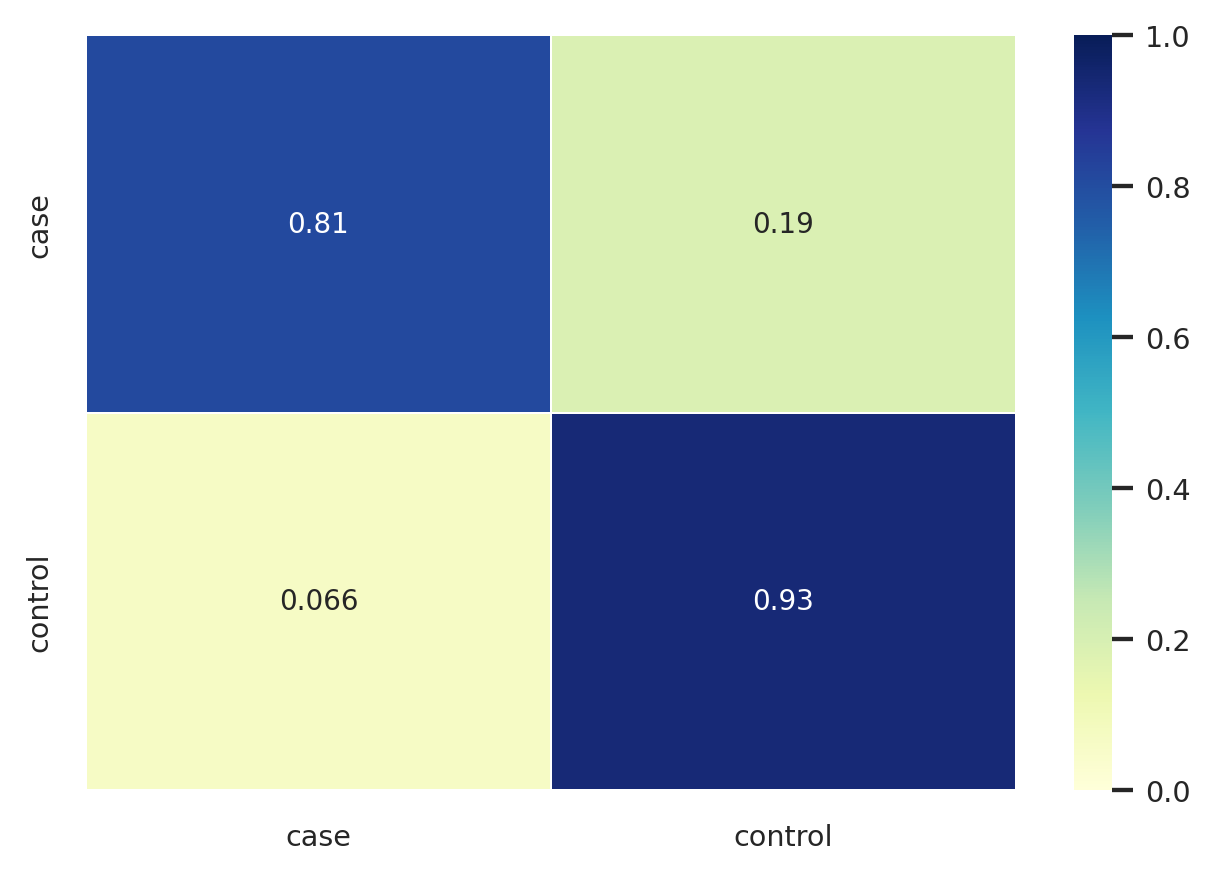

In [12]:
matrix = confusion_matrix(Y_holdout,logistic_pred, labels=np.unique(Y_holdout))
matrix = matrix/matrix.sum(axis=1, keepdims=True)*1
df_matrix = pd.DataFrame(matrix)
df_matrix.columns = np.unique(Y_holdout)
df_matrix.index = np.unique(Y_holdout)

sns.set(font_scale=0.75)
ax = sns.heatmap(df_matrix,cmap ="YlGnBu",annot = True,vmin = 0, vmax = 1,linewidth=0.5,annot_kws={"size": 8})
plt.show()

# KNN hyperparameter tuning

In [11]:
knn = KNeighborsClassifier()

n_neighbors = [1,3,5,10,20,100]
weights = ["uniform", "distance"]
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
p = [1,2]
metric = ["euclidean","manhattan", "chebyshev", "minkowski", "wminkowski" ]



grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': algorithm,
               'p': p,
               'metric': metric}

knn_variants = RandomizedSearchCV(estimator = knn, param_distributions = grid, n_iter = 15, cv = 2, verbose=2, random_state=42)
knn_variants.fit(X,Y)
knn_variants.best_params_

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV] END algorithm=auto, metric=minkowski, n_neighbors=1, p=1, weights=distance; total time= 1.7min
[CV] END algorithm=auto, metric=minkowski, n_neighbors=1, p=1, weights=distance; total time= 2.2min
[CV] END algorithm=brute, metric=chebyshev, n_neighbors=3, p=2, weights=uniform; total time= 2.8min
[CV] END algorithm=brute, metric=chebyshev, n_neighbors=3, p=2, weights=uniform; total time= 2.4min
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, p=2, weights=uniform; total time= 1.4min
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, p=2, weights=uniform; total time= 1.5min
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=10, p=1, weights=distance; total time= 1.8min
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=10, p=1, weights=distance; total time= 1.7min
[CV] END algorithm=brute, metric=manhattan, n_neighbors=10, p=2, weights=distance; total time= 1.4min
[CV] END algorithm=brute, met

{'weights': 'distance',
 'p': 1,
 'n_neighbors': 5,
 'metric': 'euclidean',
 'algorithm': 'auto'}

## Comparing the baseline and optimized KNN performance

In [13]:
knn_baseline = model_performance(model = KNeighborsClassifier(),X=X,Y=Y,X_holdout=X_holdout,Y_holdout = Y_holdout)[0]
knn_optimized,knn_pred = model_performance(model = KNeighborsClassifier(**{'weights': 'distance','p': 1,'n_neighbors': 5,'metric': 'euclidean','algorithm': 'auto'}),
                                 X=X,Y=Y,X_holdout = X_holdout,Y_holdout = Y_holdout)

In [14]:
knn_performance = pd.concat([knn_baseline,knn_optimized], axis = 0,ignore_index = True)
knn_performance = knn_performance.rename(index = {0 : "baseline_knn", 1 : "optimized_knn"})
knn_performance

,precision,recall,f1,accuracy,AUROC
baseline_knn,0.834335,0.83432,0.834318,0.83432,0.925352
optimized_knn,0.856733,0.85672,0.856719,0.85672,0.948205


## Optimized KNN confusion matrix

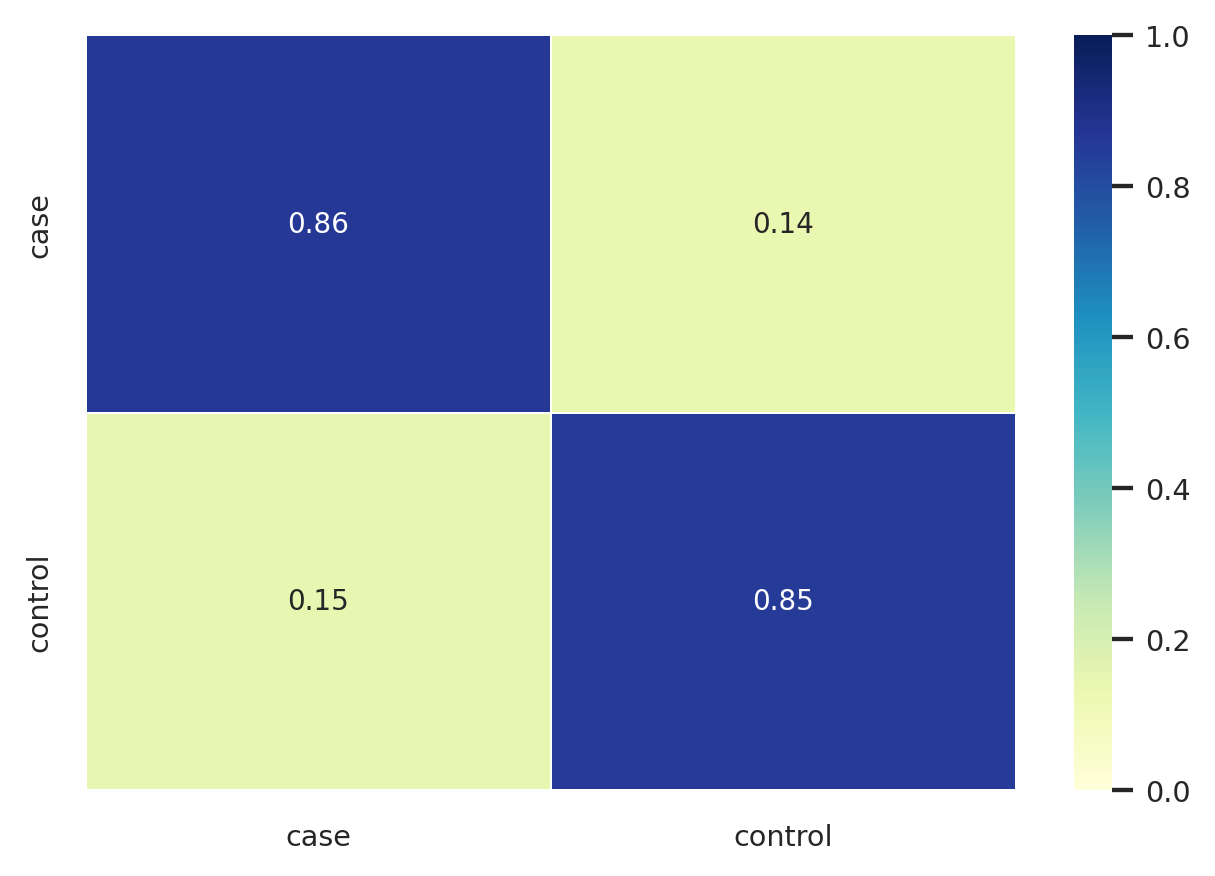

In [15]:
matrix = confusion_matrix(Y_holdout,knn_pred, labels=np.unique(Y_holdout))
matrix = matrix/matrix.sum(axis=1, keepdims=True)*1
df_matrix = pd.DataFrame(matrix)
df_matrix.columns = np.unique(Y_holdout)
df_matrix.index = np.unique(Y_holdout)

sns.set(font_scale=0.75)
ax = sns.heatmap(df_matrix,cmap ="YlGnBu",annot = True,vmin = 0, vmax = 1,linewidth=0.5,annot_kws={"size": 8})
plt.show()

# Decision tree hyperparameter tuning

In [18]:
dt = DecisionTreeClassifier()

criterion = ["gini", "entropy"]
splitter = ["best", "random"]
max_features = [None,"sqrt","log2"]
max_depth = [None,5,10,50,100]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1,2,5]


grid = {'criterion': criterion,
               'splitter': splitter,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split, 'min_samples_leaf' : min_samples_leaf}

dt_variants = RandomizedSearchCV(estimator = dt, param_distributions = grid, n_iter = 50, cv = 2, verbose=2, random_state=42)
dt_variants.fit(X,Y)
dt_variants.best_params_

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END criterion=gini, max_depth=100, max_features=None, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.9s
[CV] END criterion=gini, max_depth=100, max_features=None, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.8s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.3s
[CV] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, splitter=random; total time=   0.3s
[CV] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, splitter=random; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, splitter=best; total

{'splitter': 'best',
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 100,
 'criterion': 'entropy'}

## Comparing the baseline and optimized decision tree performance

In [16]:
dt_baseline = model_performance(model = DecisionTreeClassifier(),X=X,Y=Y,X_holdout=X_holdout,Y_holdout = Y_holdout)[0]
dt_optimized,dt_pred = model_performance(model = DecisionTreeClassifier(**{'splitter': 'best','min_samples_split': 5,'min_samples_leaf': 1,'max_features': None,'max_depth': 100,'criterion': 'entropy'}),
                                 X=X,Y=Y,X_holdout = X_holdout,Y_holdout = Y_holdout)

In [17]:
dt_performance = pd.concat([dt_baseline,dt_optimized], axis = 0,ignore_index = True)
dt_performance = dt_performance.rename(index = {0 : "baseline_dt", 1 : "optimized_dt"})
dt_performance

,precision,recall,f1,accuracy,AUROC
baseline_dt,0.878303,0.876162,0.875987,0.876162,0.959899
optimized_dt,0.877175,0.874894,0.874705,0.874894,0.959496


## Optimized decision tree confusion matrix

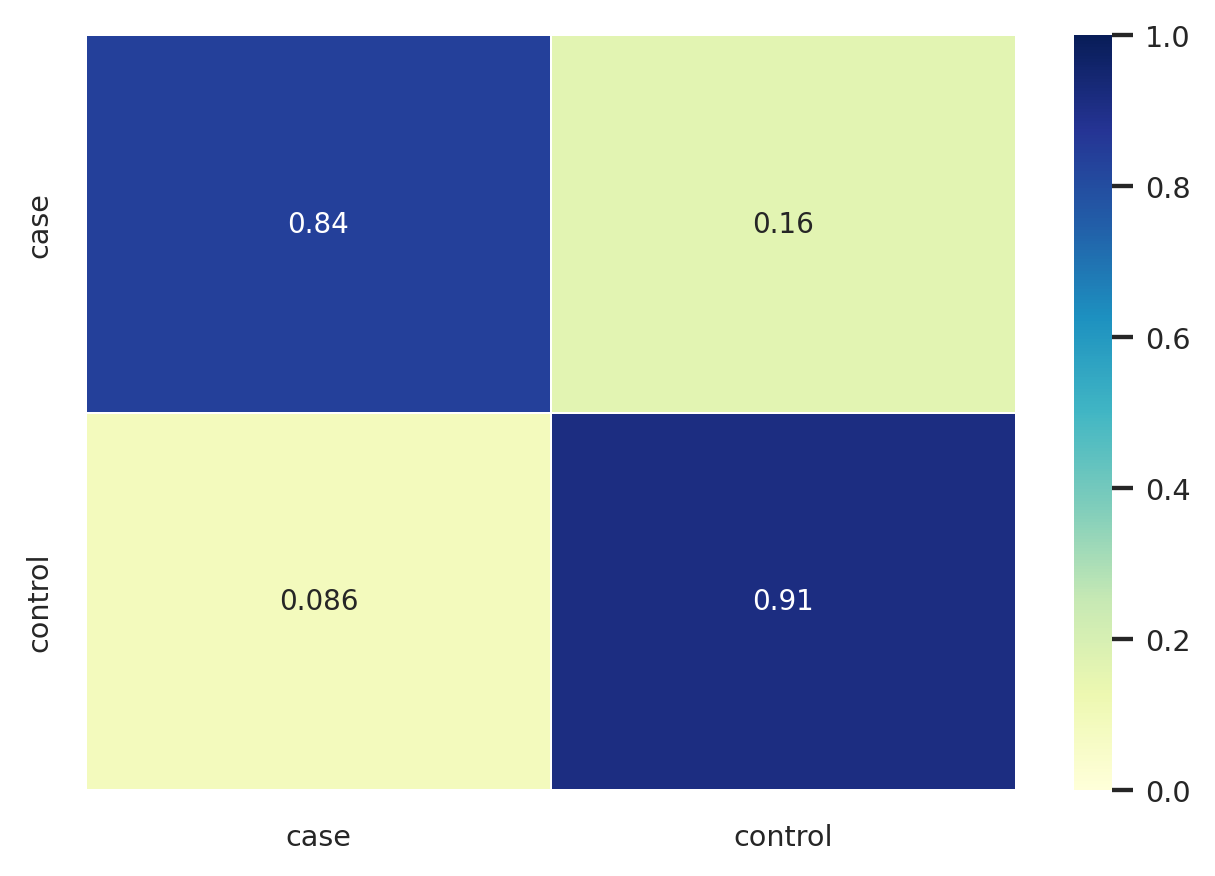

In [18]:
matrix = confusion_matrix(Y_holdout,dt_pred, labels=np.unique(Y_holdout))
matrix = matrix/matrix.sum(axis=1, keepdims=True)*1
df_matrix = pd.DataFrame(matrix)
df_matrix.columns = np.unique(Y_holdout)
df_matrix.index = np.unique(Y_holdout)

sns.set(font_scale=0.75)
ax = sns.heatmap(df_matrix,cmap ="YlGnBu",annot = True,vmin = 0, vmax = 1,linewidth=0.5,annot_kws={"size": 8})
plt.show()

# MLP hyperparameter tuning

In [22]:
mlp = MLPClassifier()


hidden_layer_sizes = [(20,),(50,),(100,),(200,)]
activation = ["identity", "logistic", "tanh", "relu"]
solver = ["lbfgs", "sgd", "adam"]
alpha = [0.0001, 0.001, 0.00001,0.01]
learning_rate = ["constant", "invscaling", "adaptive"]

grid = {'hidden_layer_sizes': hidden_layer_sizes,
               'activation': activation,
               'solver': solver,
               'alpha': alpha,
               'learning_rate': learning_rate}

mlp_variants = RandomizedSearchCV(estimator = mlp, param_distributions = grid, n_iter = 15, cv = 2, verbose=2, random_state=42)
mlp_variants.fit(X,Y)
mlp_variants.best_params_

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs; total time=  22.1s
[CV] END activation=logistic, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs; total time=  20.7s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  59.5s
[CV] END activation=identity, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  30.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd; total time=  10.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd; total time=  13.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=invscaling, solver=lbfgs; total time=  33.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), le

{'solver': 'lbfgs',
 'learning_rate': 'invscaling',
 'hidden_layer_sizes': (200,),
 'alpha': 1e-05,
 'activation': 'relu'}

## Comparing the baseline and optimized MLP performance

In [22]:
mlp_baseline = model_performance(model = MLPClassifier(),X=X,Y=Y,X_holdout=X_holdout,Y_holdout = Y_holdout)[0]
mlp_optimized,mlp_pred = model_performance(model = MLPClassifier(**{'solver': 'lbfgs','learning_rate': 'invscaling','hidden_layer_sizes': (200,),'alpha': 1e-05,'activation': 'relu'}),
                                 X=X,Y=Y,X_holdout = X_holdout,Y_holdout = Y_holdout)

In [23]:
mlp_performance = pd.concat([mlp_baseline,mlp_optimized], axis = 0,ignore_index = True)
mlp_performance = mlp_performance.rename(index = {0 : "baseline_mlp", 1 : "optimized_mlp"})
mlp_performance

,precision,recall,f1,accuracy,AUROC
baseline_mlp,0.864662,0.818259,0.812287,0.818259,0.946323
optimized_mlp,0.855619,0.851648,0.851233,0.851648,0.944261


## Optimized MLP confusion matrix

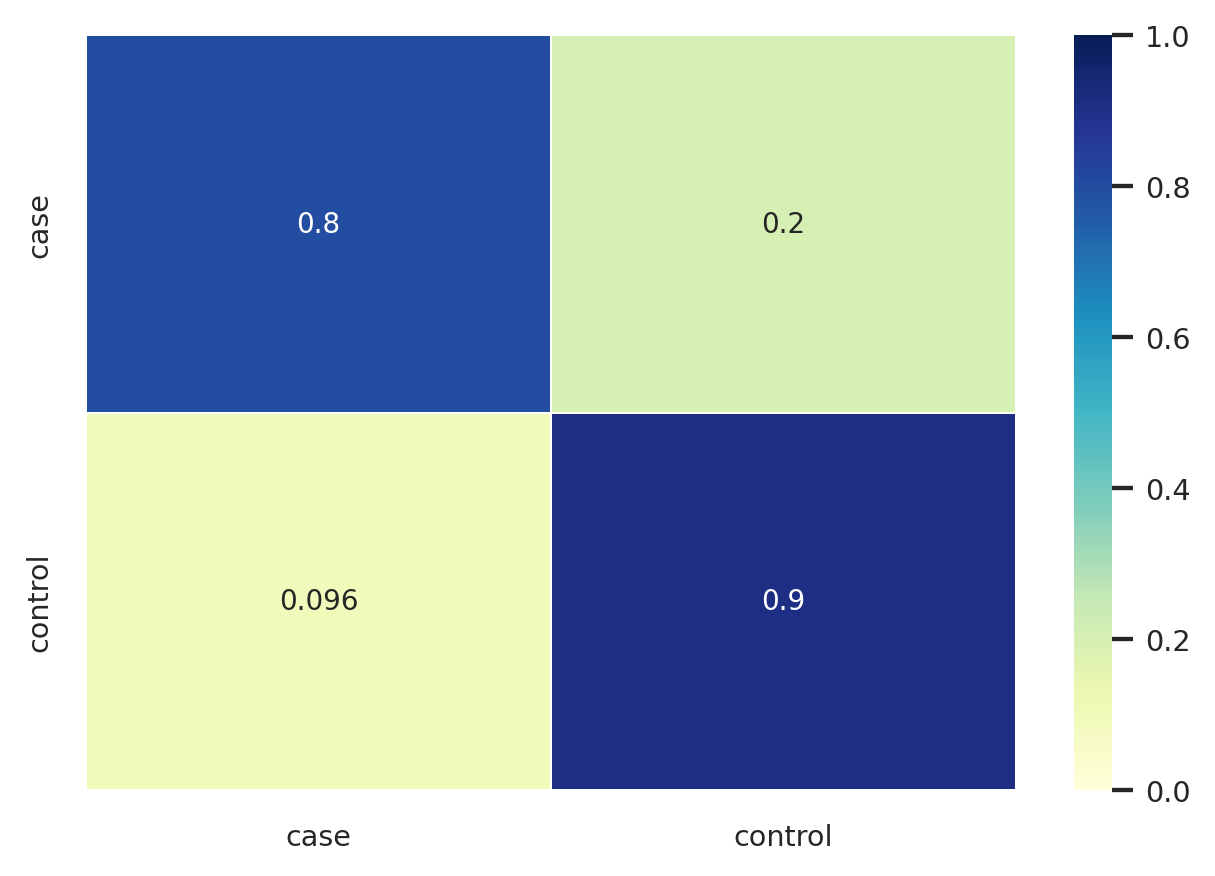

In [24]:
matrix = confusion_matrix(Y_holdout,mlp_pred, labels=np.unique(Y_holdout))
matrix = matrix/matrix.sum(axis=1, keepdims=True)*1
df_matrix = pd.DataFrame(matrix)
df_matrix.columns = np.unique(Y_holdout)
df_matrix.index = np.unique(Y_holdout)

sns.set(font_scale=0.75)
ax = sns.heatmap(df_matrix,cmap ="YlGnBu",annot = True,vmin = 0, vmax = 1,linewidth=0.5,annot_kws={"size": 8})
plt.show()

# Bar graph summarizing the overall performance of the 5 optimized ML algorithms

In [35]:
overall_performance = pd.concat([logistic_performance, dt_performance, knn_performance, rf_performance, mlp_performance],axis = 0)
#overall_performance.to_csv("overall_performance.csv")
overall_performance

,precision,recall,f1,accuracy,AUROC
baseline_logistic,0.852315,0.848690,0.848300,0.848690,0.942493
optimized_logistic,0.878467,0.872781,0.872301,0.872781,0.959665
baseline_dt,0.878303,0.876162,0.875987,0.876162,0.959899
optimized_dt,0.877175,0.874894,0.874705,0.874894,0.959496
baseline_knn,0.834335,0.834320,0.834318,0.834320,0.925352
optimized_knn,0.856733,0.856720,0.856719,0.856720,0.948205
baseline_randomforest,0.881088,0.877853,0.877593,0.877853,0.961585
optimized_randomforest,0.879383,0.876162,0.875899,0.876162,0.961716
baseline_mlp,0.864662,0.818259,0.812287,0.818259,0.946323
optimized_mlp,0.855619,0.851648,0.851233,0.851648,0.944261


In [44]:
overall_performance = pd.read_csv("overall_performance.csv",sep=",", header=0,index_col=0)
df_opt = overall_performance.iloc[[1,3,5,7,9],:]
df_opt

,precision,recall,f1,accuracy,AUROC
optimized_logistic,0.890711,0.882925,0.882339,0.882925,0.965761
optimized_dt,0.894027,0.891378,0.891195,0.891378,0.966842
optimized_knn,0.882454,0.882079,0.882051,0.882079,0.960272
optimized_randomforest,0.897940,0.893914,0.893645,0.893914,0.969234
optimized_mlp,0.858219,0.857988,0.857965,0.857988,0.953270


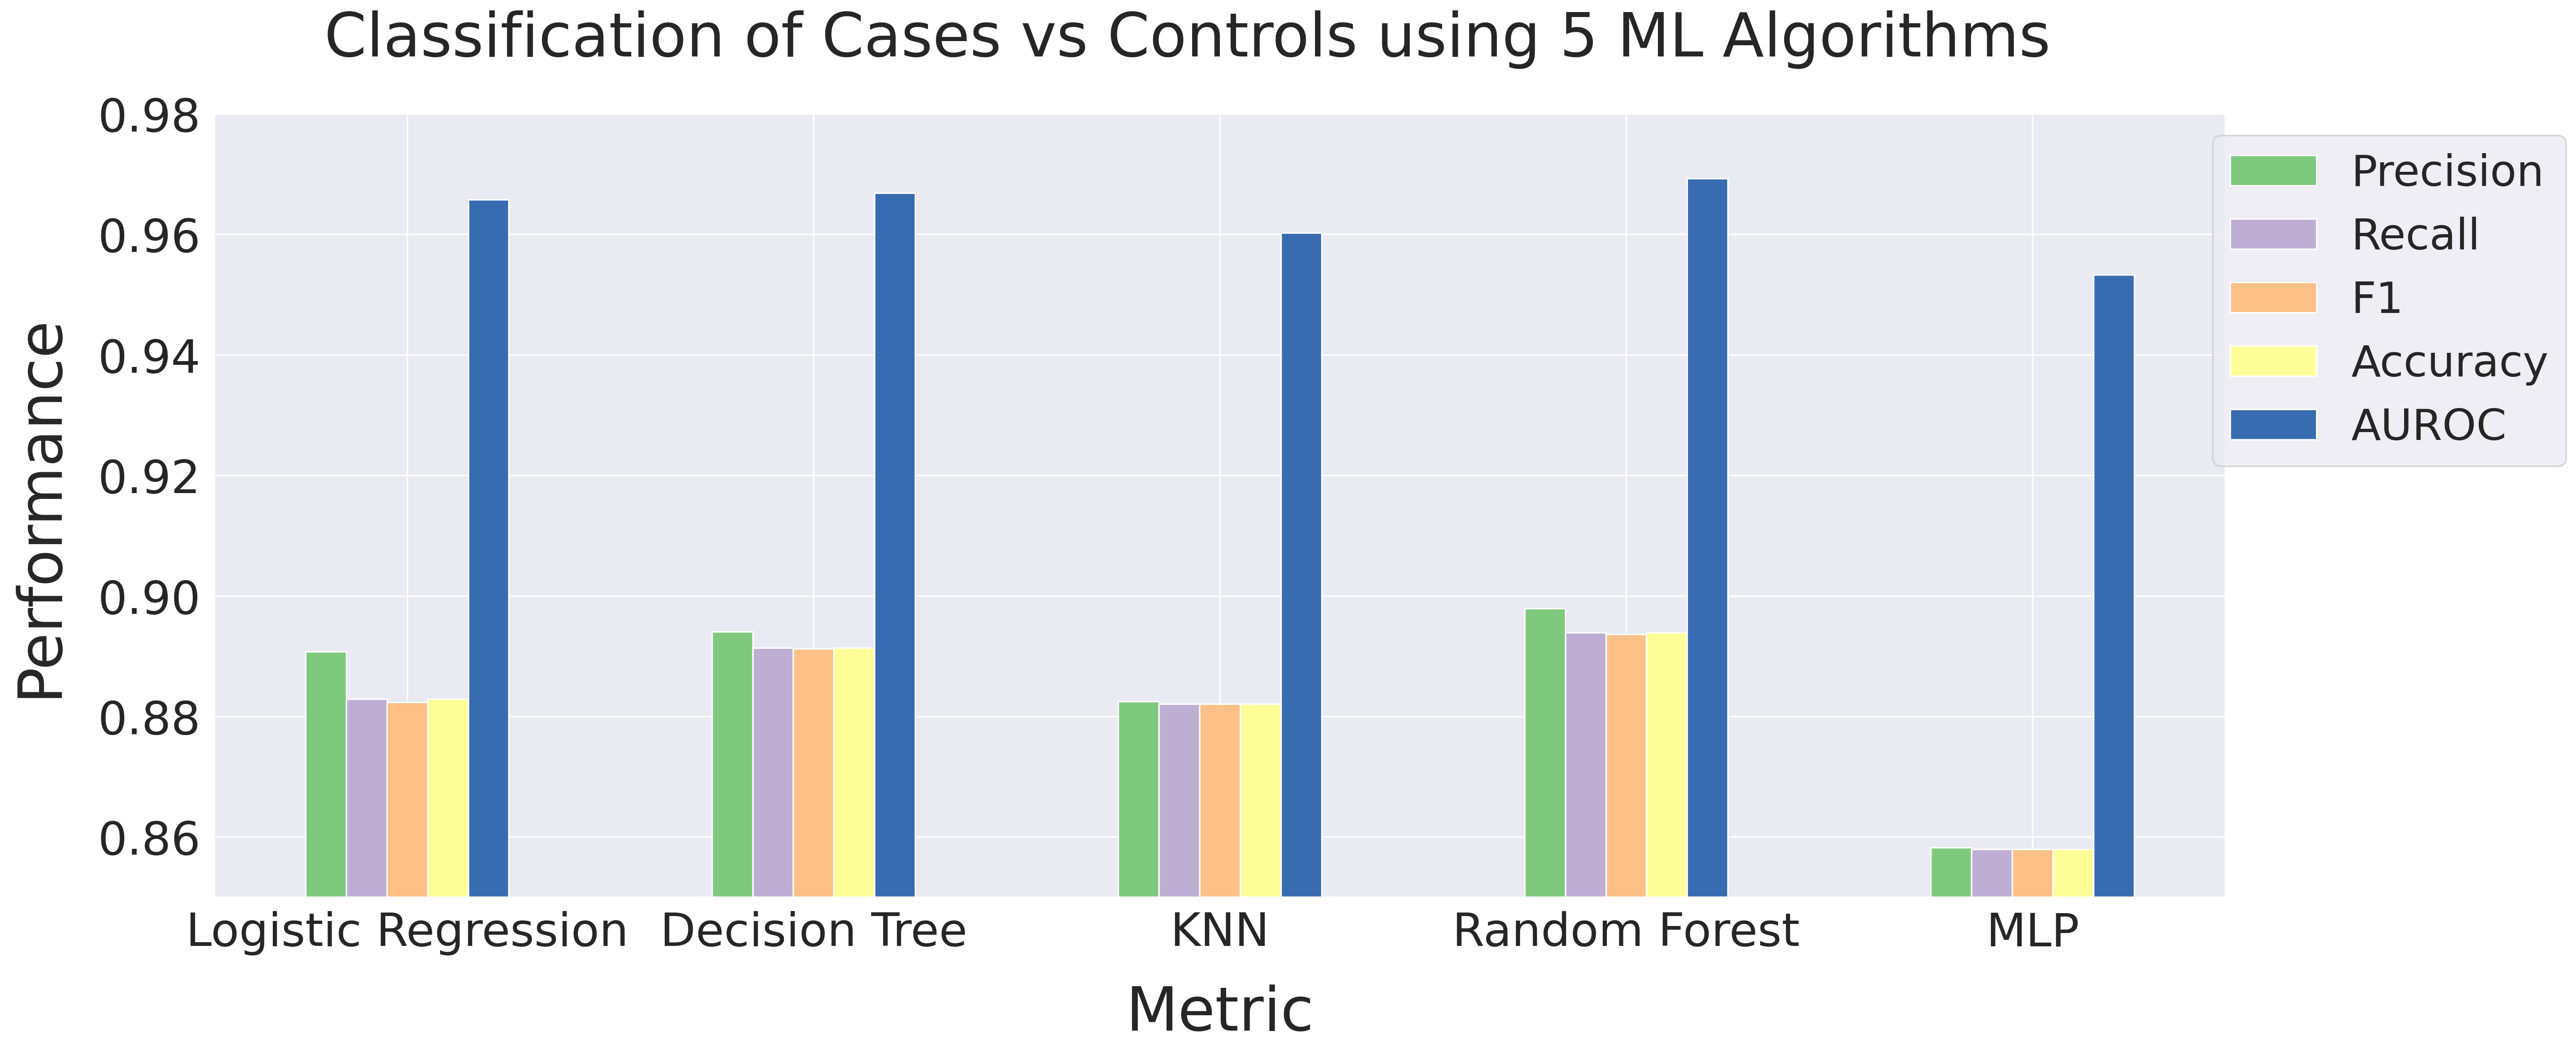

In [54]:
ind = np.arange(5)
fig, ax = plt.subplots(figsize = (25, 10))

precision_bar = ax.bar(ind - 0.2, df_opt.precision,alpha=1,width = 0.1,capsize = 10, color = '#7fc97f',align = 'center')
recall_bar = ax.bar(ind - 0.1 , df_opt.recall,alpha=1, width = 0.1,capsize = 10, color = '#beaed4', align = 'center')
f1_bar = ax.bar(ind, df_opt.f1,alpha=1, width = 0.1,capsize = 10, color = '#fdc086',align = 'center')
accuracy_bar = ax.bar(ind + 0.1, df_opt.accuracy,alpha=1, width = 0.1,capsize = 10, color = '#ffff99', align = 'center')
auroc_bar = ax.bar(ind + 0.2, df_opt.AUROC,alpha=1, width = 0.1,capsize = 10, color = '#386cb0', align = 'center')

ax.set_ylabel("Performance", size = 42)
ax.set_ylim([0.85,0.98])
ax.set_xlabel("Metric", size = 42)
ax.set_xticks(ind)
ax.set_xticklabels(["Logistic Regression","Decision Tree","KNN","Random Forest","MLP"],rotation = 0)
ax.tick_params(axis='both', labelsize=32)
ax.legend((precision_bar[0], recall_bar[0],f1_bar[0],accuracy_bar[0],auroc_bar[0]), ('Precision','Recall','F1', 'Accuracy',"AUROC"),
          prop={'size': 30}, bbox_to_anchor=(1.18, 1), loc='upper right')
ax.yaxis.grid(True)
fig.suptitle('Classification of Cases vs Controls using 5 ML Algorithms', fontsize=42)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
vis = ax.get_figure()
vis.savefig("Fig2A.pdf", bbox_inches='tight')